In [147]:
import visualize
from importlib import reload

reload(visualize)

<module 'visualize' from '/home/ari/Documents/RLDonkeyCar/analysis/visualize.py'>

Okay so here are the results that I've managed to do thus far. 

I tried making a bigger and more ambitous track at school but that did not pan out that well. 
<img src="track.jpg" width="500">

## Real Donkey car

I tried making a bigger and more ambitoius track at the school. However, my results were significantly worse there than home and running the results was not as convenient. I am not totally sure why but my guess is that the shiny floor and lighting conditions caused a lot of glare that might have confused the car. So I settled to run some results home to at least get some benchmark on the performance. For this I used a track modeled into a shape of figure 8.

<img src="track.jpg" width="500">

I chose this shape because it has both left and right turns and it is also symmetric. My thinking was that this way I could see that once the car made it through the first half, I could immediately see if it also generalized on the second half. To some extent this actually happened but generally not. The track seems simple but it is not that trivial for the car to navigate.

Currently my approach for this problem is:
- Input: Single grayscaled image that is cropped from the original 120x160px to 80x160px and resized to 40x40. Upper part of image is mostly surroundings that should not be necessary for solving the problem. I have also tried RGB images and frame stacking but those did not seem to help. The image is fed through the encoder and the resulting embedding is then augmented with a history of 5 previous controls.
- Encoder: Two layers the first one with 16 and the second one with 32 channels and both with kernel size of 3x3. After these is a single fully connected layer with dimension of 32. I've tried using both a determinisctic and variational autoencoder but the variational seems to work better.
- SAC: I use two layer MLP networks with hidden size of 64.
- Training: The model is updated 600 times between each episode with a batch size of 128. Learning rate for the critic and actor is 1e-4 and for the encoder 1e-5.
- The critic optimizer also has the encoder parameters. This way when critic optimizer is stepped it also trains the encoder layers. After this the encoder is also updated with the VAE loss using another optimizer. I have not investigated how does this actually effect the performance of the algorithm more throughly but it seems to help. However, this seems a bit schetchy way to do use critic loss for the encoder and I don't know if a proper way would somehow be to calculate a combined loss from the critic loss and encoder loss which would also enable to weight the losses differently for the encoder.

Experimental setup:
- The control loop is driven at 10Hz frequenzy. The car runs at 20Hz.
- Each run is started with 5 random episodes.
- Each episode is started from the same point.
- Episodes are terminated when the car drives off the track. This is essentially determined by counting balck pixels in front of the car.
- Each step that the car drives on the track yields a reward of 1. When car drives off track it receives a penalty of -10.
- Throttle is fixed with the goal of maintaining a constant speed. This however is easier said and done and now that I've done more driving I've noticed many problems with this approach.
- The run is continued until three consecutive episodes of maximum length of 500 steps which is about 3 laps. This does not necessarily mean that the algorithm has converged, and even after this it is still possible for the car to do something stupid. However, there is not much sense in driving around after this point if the point is not to test the stability of the solution.


### Results on the real Donkey car

I did a couple of runs with both the 


In the first plot we have the reward per episode from all the runs and a mean average taken over the episodes

Run 1, Episodes: 69, Time: 39 minutes
Run 2, Episodes: 84, Time: 50 minutes
Run 3, Episodes: 94, Time: 58 minutes
Run 4, Episodes: 80, Time: 51 minutes


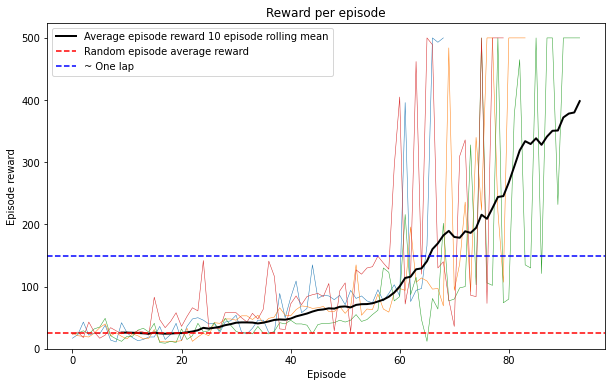

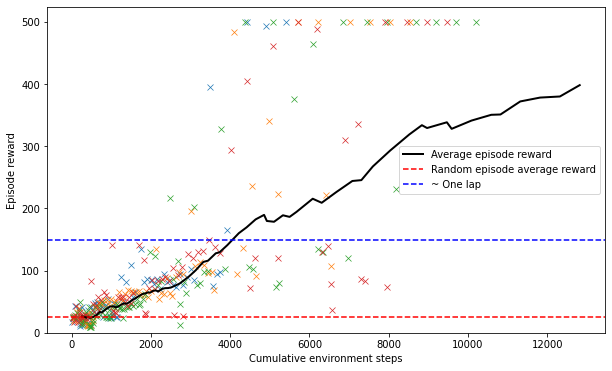

In [148]:
visualize.visualize_run("../records/real_not_pretrained_1/", real_car=True)

### The main takeaways from these plots.

Once the car drives around the track once, it can usually repeat this. This is not always the case and even when the car has succeeded before, 

### Pretrainded VAE

Run 1, Episodes: 100, Time: 54 minutes
Run 2, Episodes: 85, Time: 50 minutes
Run 3, Episodes: 100, Time: 68 minutes
Run 4, Episodes: 169, Time: 80 minutes


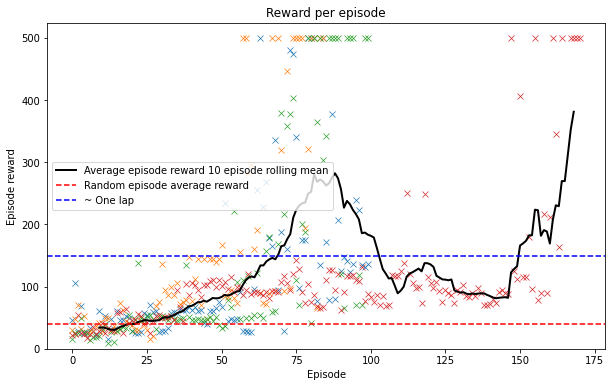

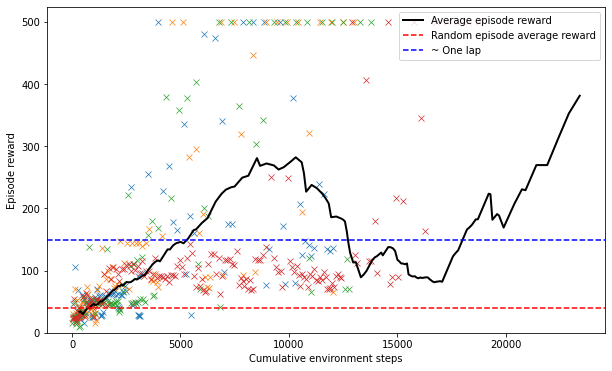

In [134]:
visualize.visualize_run("../records/real_pretrained_1/", real_car=True)

### Simulator

Here are some simulator runs that I did with the same setup that I use for the real car.

I tested both pretrained and pretrained and non pretrained encoders as well as updating

Run 0, Episodes: 50, Time: 38 minutes
Run 1, Episodes: 50, Time: 57 minutes
Run 2, Episodes: 50, Time: 58 minutes
Run 3, Episodes: 50, Time: 40 minutes
Run 4, Episodes: 50, Time: 39 minutes
Run 5, Episodes: 50, Time: 33 minutes
Run 6, Episodes: 50, Time: 40 minutes
Run 7, Episodes: 50, Time: 48 minutes
Run 8, Episodes: 50, Time: 51 minutes
Run 9, Episodes: 50, Time: 34 minutes
Run 10, Episodes: 50, Time: 33 minutes
Run 11, Episodes: 50, Time: 35 minutes
Run 12, Episodes: 50, Time: 48 minutes
Run 13, Episodes: 50, Time: 46 minutes
Run 14, Episodes: 50, Time: 42 minutes
Run 15, Episodes: 50, Time: 37 minutes
Run 16, Episodes: 50, Time: 35 minutes
Run 17, Episodes: 50, Time: 53 minutes
Run 18, Episodes: 50, Time: 35 minutes
Run 19, Episodes: 50, Time: 51 minutes
Run 20, Episodes: 50, Time: 33 minutes


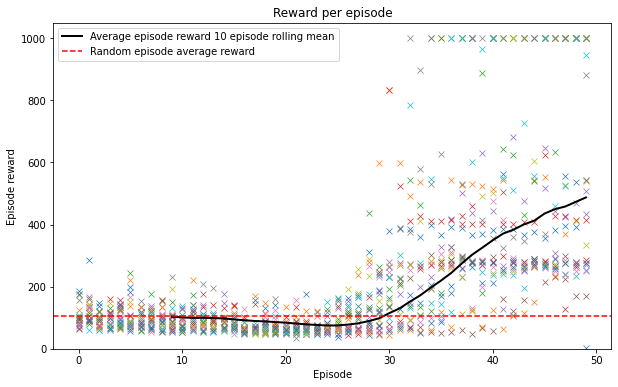

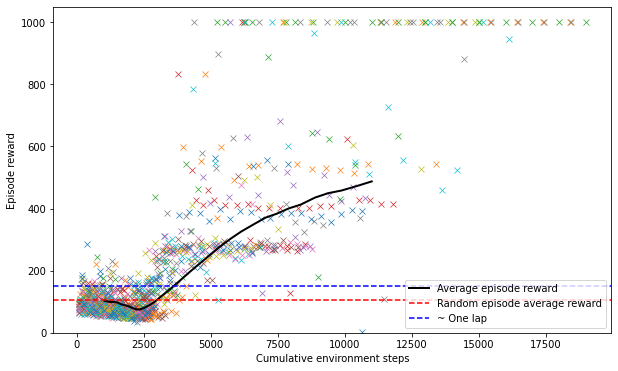

In [114]:
visualize_run("../records/sim_not_pretrained_no_critic_encoder_update/", episodes=50)

Run 0, Episodes: 84, Time: 131 minutes
Run 1, Episodes: 70, Time: 69 minutes
Run 2, Episodes: 77, Time: 60 minutes
Run 3, Episodes: 57, Time: 42 minutes
Run 4, Episodes: 70, Time: 54 minutes
Run 5, Episodes: 90, Time: 114 minutes
Run 6, Episodes: 90, Time: 108 minutes
Run 7, Episodes: 70, Time: 70 minutes
Run 8, Episodes: 70, Time: 64 minutes
Run 9, Episodes: 100, Time: 79 minutes
Run 10, Episodes: 70, Time: 81 minutes
Run 11, Episodes: 70, Time: 87 minutes
Run 12, Episodes: 84, Time: 97 minutes
Run 13, Episodes: 70, Time: 83 minutes
Run 14, Episodes: 70, Time: 78 minutes
Run 15, Episodes: 25, Time: 15 minutes
Run 16, Episodes: 70, Time: 96 minutes


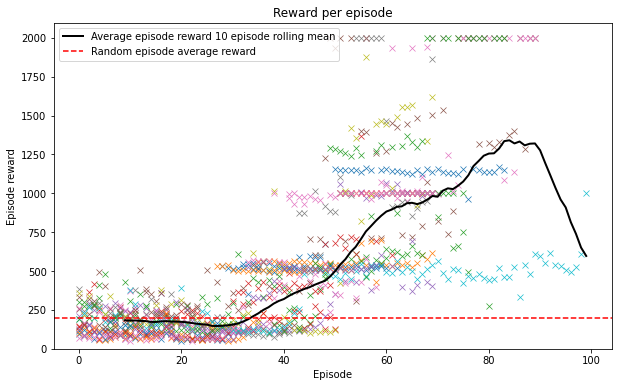

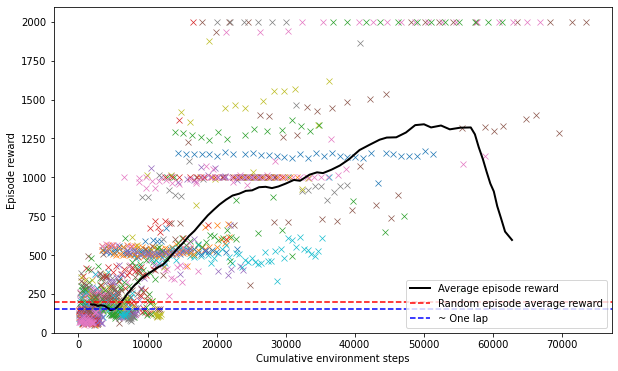

In [115]:
visualize_run("../records/sim_not_pretrained_small_gs_1/")

Run 0, Episodes: 50, Time: 51 minutes
Run 1, Episodes: 50, Time: 36 minutes
Run 2, Episodes: 50, Time: 53 minutes
Run 3, Episodes: 50, Time: 28 minutes
Run 4, Episodes: 50, Time: 50 minutes
Run 5, Episodes: 50, Time: 42 minutes
Run 6, Episodes: 50, Time: 33 minutes
Run 7, Episodes: 50, Time: 28 minutes
Run 8, Episodes: 50, Time: 34 minutes
Run 9, Episodes: 50, Time: 46 minutes


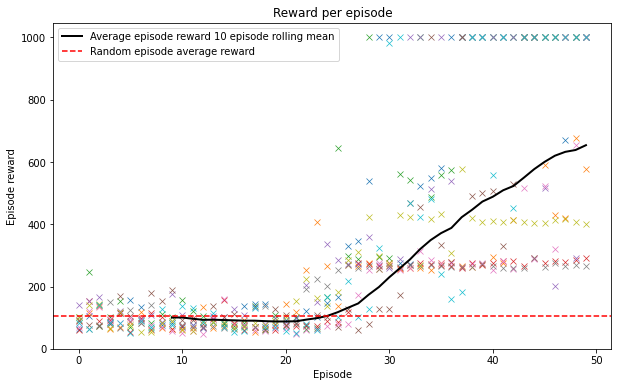

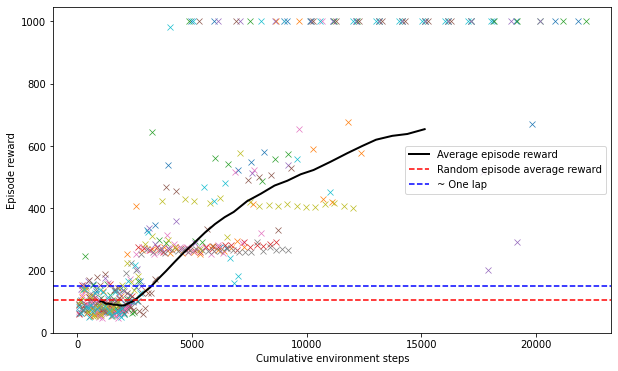

In [116]:
visualize_run("../records/sim_pretrained/", episodes=50)

Run 0, Episodes: 70, Time: 58 minutes
Run 1, Episodes: 70, Time: 61 minutes
Run 2, Episodes: 70, Time: 53 minutes
Run 3, Episodes: 70, Time: 64 minutes
Run 4, Episodes: 70, Time: 46 minutes
Run 5, Episodes: 70, Time: 76 minutes


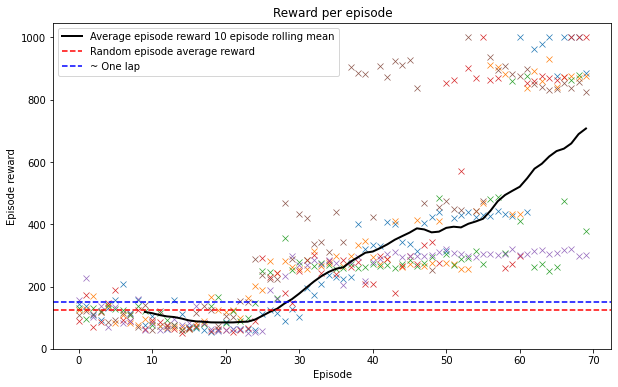

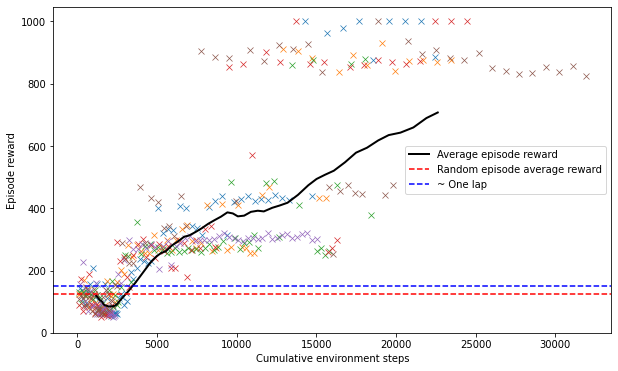

In [107]:
visualize_run("../records/sim_pretrained/", episodes=70)